## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import display

import pickle

## Data preprocessing

In [2]:
# raw_data1 = pd.read_csv('data\ods032.csv', delimiter=';', parse_dates=['Datetime'], index_col='Datetime')
raw_data2 = pd.read_csv('data\ods032.csv', delimiter=';')

In [11]:
data = raw_data2.copy()
data = data[data.Region == "Belgium"]
data['Datetime'] = pd.to_datetime(data['Datetime'], utc=True)
data = data[['Datetime','Measured & Upscaled']]
data = data.rename(columns={'Measured & Upscaled':'generation'})
data.set_index("Datetime", inplace=True)
data = data.sort_index()
# data = data['2019-01-01':'2023-12-31']
data = data.ffill().bfill()
# data = data['generation'].values.reshape(-1, 1)
data['day_of_year'] = data.index.dayofyear / 365.0
data['day_of_year_sin'] = np.sin(2 * np.pi * data.index.dayofyear / 365)
data['day_of_year_cos'] = np.cos(2 * np.pi * data.index.dayofyear / 365)
data['hour_sin'] = np.sin(2 * np.pi * data.index.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data.index.hour / 24)
data_prescaled = data.copy()
display(data)
display(data.describe())

,generation,day_of_year,day_of_year_sin,day_of_year_cos,hour_sin,hour_cos
Datetime,,,,,,
2018-08-31 22:00:00+00:00,0.0,0.665753,-0.863142,-0.504961,-0.500000,0.866025
2018-08-31 22:15:00+00:00,0.0,0.665753,-0.863142,-0.504961,-0.500000,0.866025
2018-08-31 22:30:00+00:00,0.0,0.665753,-0.863142,-0.504961,-0.500000,0.866025
2018-08-31 22:45:00+00:00,0.0,0.665753,-0.863142,-0.504961,-0.500000,0.866025
2018-08-31 23:00:00+00:00,0.0,0.665753,-0.863142,-0.504961,-0.258819,0.965926
...,...,...,...,...,...,...
2024-10-01 20:45:00+00:00,0.0,0.753425,-0.999769,0.021516,-0.866025,0.500000
2024-10-01 21:00:00+00:00,0.0,0.753425,-0.999769,0.021516,-0.707107,0.707107
2024-10-01 21:15:00+00:00,0.0,0.753425,-0.999769,0.021516,-0.707107,0.707107


,generation,day_of_year,day_of_year_sin,day_of_year_cos,hour_sin,hour_cos
count,213408.000000,213408.000000,213408.000000,213408.000000,2.134080e+05,2.134080e+05
mean,641.872209,0.504609,-0.013775,-0.003022,-4.644658e-18,-6.476717e-17
std,1099.463303,0.287817,0.711063,0.702990,7.071084e-01,7.071084e-01
min,0.000000,0.002740,-0.999991,-0.999963,-1.000000e+00,-1.000000e+00
25%,0.000000,0.254795,-0.729558,-0.696376,-7.071068e-01,-7.071068e-01
50%,2.661500,0.509589,-0.025818,-0.012910,6.123234e-17,-6.123234e-17
75%,896.572000,0.747945,0.699458,0.702527,7.071068e-01,7.071068e-01
max,7526.474000,1.002740,0.999991,1.000000,1.000000e+00,1.000000e+00


<Axes: xlabel='Datetime', ylabel='generation'>

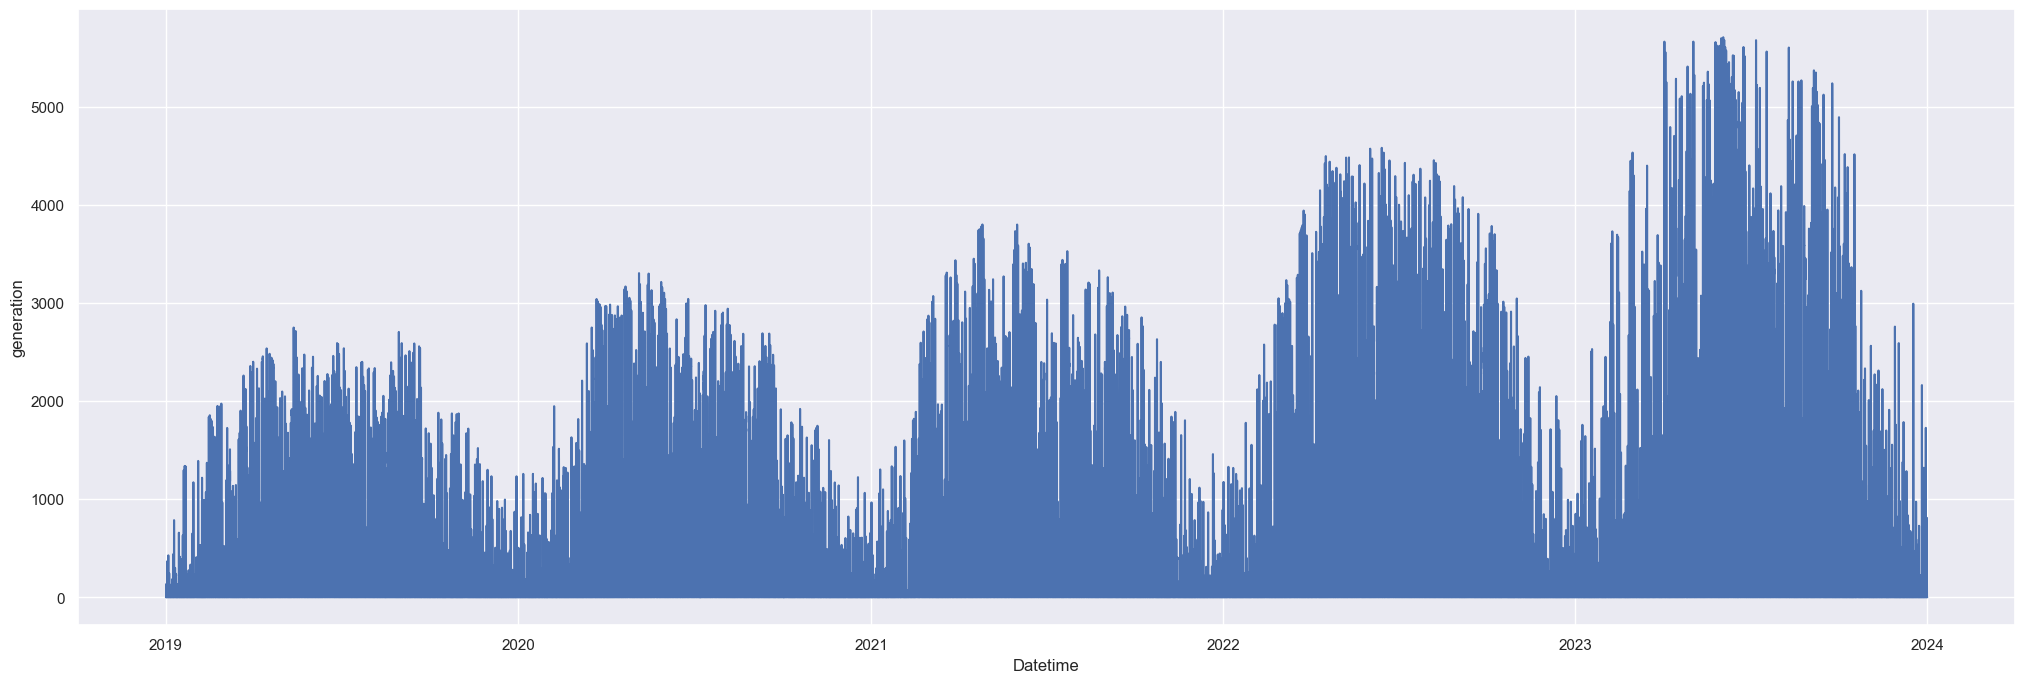

In [151]:
plt.figure(figsize=(25,8))
sns.lineplot(data.generation)

In [280]:
cv = data['generation'].std() / data['generation'].mean()
print(f"Coefficient of Variation\t{cv:.3f}")

iqr = data['generation'].quantile(0.75) - data['generation'].quantile(0.25)
print(f"Interquartile Range (IQR)\t{iqr:.3f}")

hourly_variation = data['generation'].resample('h').std()
print(f"Average Hourly Variation\t{hourly_variation.mean():.3f}")

daily_variation = data['generation'].resample('D').std()
print(f"Average Daily Variation\t\t{daily_variation.mean():.3f}")

# Monthly variation
monthly_variation = data['generation'].resample('ME').std()
print(f"Average Monthly Variation\t{monthly_variation.mean():.3f}")

Coefficient of Variation	1.672
Interquartile Range (IQR)	851.291
Average Hourly Variation	57.516
Average Daily Variation		737.438
Average Monthly Variation	814.156


In [12]:
date_from = '2023-06-01'
date_2019_start = '2019-01-01'
date_2024_start = '2024-01-01'
date_2023_end = '2023-12-31'

duration_backward = 7
duration_forward = 7

date_from_dt = datetime.strptime(date_from, '%Y-%m-%d')
date_previous_dt = date_from_dt - timedelta(days=1)
date_previous = date_previous_dt.strftime('%Y-%m-%d')

date_week_start_dt = date_from_dt - timedelta(days=7)
date_week_start = date_week_start_dt.strftime('%Y-%m-%d')
df_week = data[date_week_start:date_previous]

date_month_start_dt = date_from_dt - timedelta(days=30)
date_month_start = date_month_start_dt.strftime('%Y-%m-%d')
df_month = data[date_month_start:date_previous]

date_start_dt = date_from_dt - timedelta(days=duration_backward)
date_start = date_start_dt.strftime('%Y-%m-%d')
df_backward = data[date_start:date_previous]

date_to_pred_dt = date_from_dt + timedelta(days=duration_forward-1)
date_to_pred = date_to_pred_dt.strftime('%Y-%m-%d')
df_forward = data[date_from:date_to_pred]
df_week_forward = data[date_week_start:date_to_pred]
df_month_forward = data[date_month_start:date_to_pred]
df_backward_forward = data[date_start:date_to_pred]
df_from2019 = data[date_2019_start:date_previous]
df_2019_2023 = data[date_2019_start:date_2023_end]
df_2024 = data[date_2024_start:]

dfs = ['df_backward', 'df_backward_forward', 'df_month', 'df_month_forward', 'df_week', 'df_week_forward', 'df_forward', 'df_from2019', 'df_2019_2023', 'df_2024']
dfs_max_length = max(len(name) for name in dfs)
for df_name in dfs:
    df = globals()[df_name]
    print(f"{df_name.ljust(dfs_max_length)}\t{df.iloc[0].name.strftime('%Y-%m-%d %H:%M')} - {df.iloc[-1].name.strftime('%Y-%m-%d %H:%M')}")

df_backward        	2023-05-25 00:00 - 2023-05-31 23:45
df_backward_forward	2023-05-25 00:00 - 2023-06-07 23:45
df_month           	2023-05-02 00:00 - 2023-05-31 23:45
df_month_forward   	2023-05-02 00:00 - 2023-06-07 23:45
df_week            	2023-05-25 00:00 - 2023-05-31 23:45
df_week_forward    	2023-05-25 00:00 - 2023-06-07 23:45
df_forward         	2023-06-01 00:00 - 2023-06-07 23:45
df_from2019        	2019-01-01 00:00 - 2023-05-31 23:45
df_2019_2023       	2019-01-01 00:00 - 2023-12-31 23:45
df_2024            	2024-01-01 00:00 - 2024-10-01 21:45


<Axes: xlabel='Datetime', ylabel='generation'>

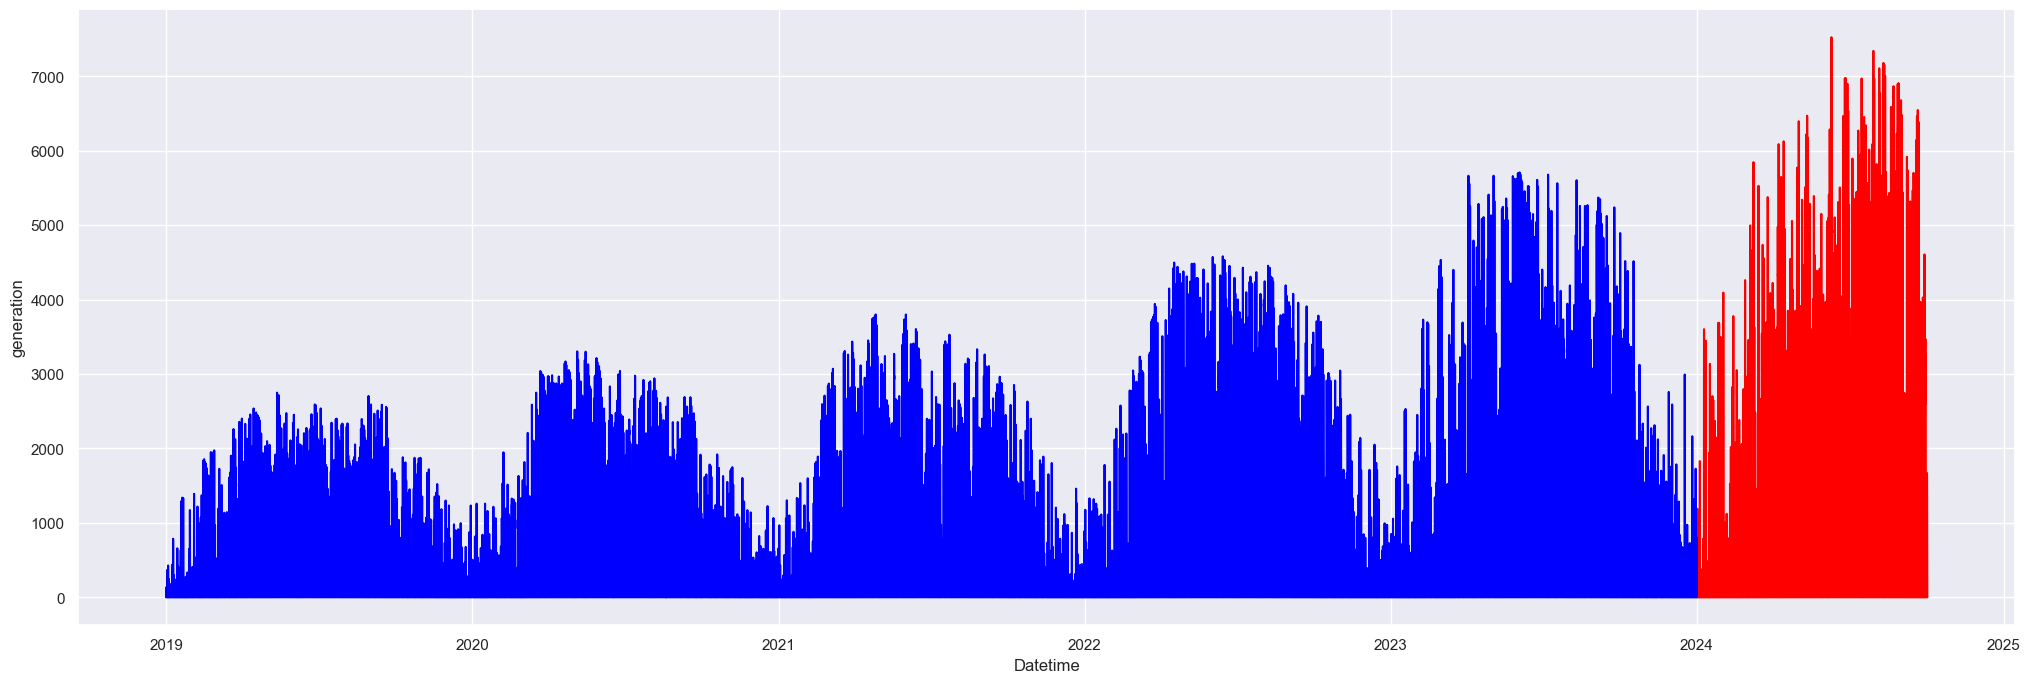

In [13]:
data = df_2019_2023.copy()
data_forward = df_2024.copy()

plt.figure(figsize=(25,8))
sns.lineplot(data_forward.generation, color='red')
sns.lineplot(data.generation, color='blue')

In [273]:
data.columns

Index(['generation', 'day_of_year', 'hour_sin', 'hour_cos', 'day_of_year_sin',
       'day_of_year_cos'],
      dtype='object')

In [14]:
# Normalise data
scaler = MinMaxScaler(feature_range=(0, 1))
data['generation'] = scaler.fit_transform(data[['generation']])

# data = data[['generation', 'day_of_year', 'hour_sin', 'hour_cos']]

# Set sequence length (e.g., 96 timesteps = past 24 hours)
seq_len = 96

# Create sequences and labels
X, y = [], []
for i in range(seq_len, len(data)):
    X.append(data.iloc[i-seq_len:i].values)  # Collect past seq_len values for all features
    y.append(data.iloc[i]['generation'])     # Target is the 'generation' value at each time step

X, y = np.array(X), np.array(y)  # Convert to numpy arrays

## Model

In [15]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),  # X.shape[2] is now the number of features (e.g., 4)
    LSTM(50),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, mode='min', restore_best_weights=True)

history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

model.save('keras-lstm-2019-2023-4features.h5')

Epoch 1/100
4380/4380 [==============================] - 123s 26ms/step - loss: 2.4658e-04 - val_loss: 8.8934e-05
Epoch 2/100
4380/4380 [==============================] - 98s 22ms/step - loss: 5.4058e-05 - val_loss: 8.8809e-05
Epoch 3/100
4380/4380 [==============================] - 100s 23ms/step - loss: 4.5340e-05 - val_loss: 6.4230e-05
Epoch 4/100
4380/4380 [==============================] - 99s 23ms/step - loss: 4.1432e-05 - val_loss: 5.6349e-05
Epoch 5/100
4380/4380 [==============================] - 94s 22ms/step - loss: 3.9224e-05 - val_loss: 6.1258e-05
Epoch 6/100
4380/4380 [==============================] - 98s 22ms/step - loss: 3.8391e-05 - val_loss: 5.3419e-05


## Predict

In [23]:
# Get last sequence with all features
last_sequence = data[-seq_len:].values  # Now includes all features
last_sequence = last_sequence.reshape((1, seq_len, last_sequence.shape[1]))  # Reshape to (1, seq_len, num_features)

# Predict the next 7 days (672 timesteps)

days_to_predict = 180
samples_per_day = 96
values_to_predict = days_to_predict * samples_per_day

predicted_values = []
for i in range(days_to_predict*samples_per_day):
    print(f'\n{i+1} / {values_to_predict}')
    predicted_value = model.predict(last_sequence)
    predicted_values.append(predicted_value[0, 0])  # Store the predicted 'generation' value
    
    # Create a new row for the next timestep with the predicted generation value
    # Update time-based features
    next_day_of_year = ((data.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).dayofyear / 365.0)
    next_hour_sin = np.sin(2 * np.pi * ((data.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
    next_hour_cos = np.cos(2 * np.pi * ((data.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
    next_day_of_year_sin = np.sin(2 * np.pi * next_day_of_year)
    next_day_of_year_cos = np.cos(2 * np.pi * next_day_of_year)


    # Combine all features for the new sequence step
    new_sequence_step = np.array([[predicted_value[0, 0], next_day_of_year, next_hour_sin, next_hour_cos, 
                                next_day_of_year_sin, next_day_of_year_cos]])  # Include all 6 features

    # Update last_sequence with the new step
    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step.reshape(1, 1, new_sequence_step.shape[1]), axis=1)

# Inverse transform the predicted values for generation
predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

predicted_values_bak = predicted_values.copy()


1 / 17280
1/1 [==============================] - 0s 39ms/step

2 / 17280
1/1 [==============================] - 0s 35ms/step

3 / 17280
1/1 [==============================] - 0s 40ms/step

4 / 17280
1/1 [==============================] - 0s 32ms/step

5 / 17280
1/1 [==============================] - 0s 30ms/step

6 / 17280
1/1 [==============================] - 0s 37ms/step

7 / 17280
1/1 [==============================] - 0s 35ms/step

8 / 17280
1/1 [==============================] - 0s 40ms/step

9 / 17280
1/1 [==============================] - 0s 36ms/step

10 / 17280
1/1 [==============================] - 0s 41ms/step

11 / 17280
1/1 [==============================] - 0s 37ms/step

12 / 17280
1/1 [==============================] - 0s 36ms/step

13 / 17280
1/1 [==============================] - 0s 30ms/step

14 / 17280
1/1 [==============================] - 0s 38ms/step

15 / 17280
1/1 [==============================] - 0s 44ms/step

16 / 17280
1/1 [==============================] 

In [24]:
# predicted_values = predicted_values_bak.copy()

## Plot

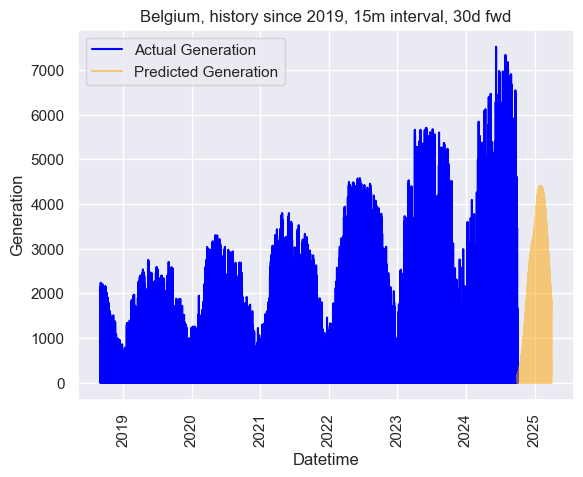

In [25]:
# Plot actual generation data
sns.lineplot(data=data_prescaled.generation[:], label='Actual Generation', color='blue')

predicted_values = np.maximum(predicted_values, 0)

# Create a new index for predicted values to follow the last date of the actual data
predicted_index = pd.date_range(start=data_prescaled.index[-1] + pd.Timedelta(minutes=15), periods=len(predicted_values), freq='15min')
sns.lineplot(x=predicted_index, y=predicted_values.flatten(), label='Predicted Generation', color='orange', alpha=0.5)

title = 'Belgium, history since 2019, 15m interval, 30d fwd'
plt.xlabel('Datetime')
plt.ylabel('Generation')
plt.title(title)
plt.xticks(rotation=90)
plt.legend()
plt.show()
# plt.savefig(title)